In [23]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

In [24]:
from src.d01_data.block_data_api import BlockDataApi
from src.d01_data.student_data_api import StudentDataApi, _block_features, _census_block_column, \
_diversity_index_features

geoid_name = 'geoid'    

# Process data
Load data indexed by the `census_block`/`Block`/`Geoid10`
1. Load FRL data
2. Load Block demographics
3. Load Block demographics computed from student data (fill in before computing the demographics from the block data)

## FLR data
This data should be indexed by the column `Geoid10` as type `int64`.

We convert the `group` column into a more coherent index. In the original data there group ids is a integer from `1` to `353` for the blocks that are grouped together and the GEOID for the blocks that stand alone. For some reason the blocks that are grouped together only have `327` (not `353`) unique group indexes. Because of this, the max value of the new index is `3311` instead of `3285` (the actual length of the vector of unique group indexes).

In [3]:
block_data_api = BlockDataApi()

In [4]:
frl_df = block_data_api.get_data(frl=True).set_index('Geoid10')
# print(frl_df)
frl_df.index.name = geoid_name
frl_df.columns = ['group', 'n', 'nFRL', 'nAALPI', 'nBoth']
frl_df['pctFRL'] = frl_df['nFRL'] / frl_df['n']
frl_df['pctAALPI'] = frl_df['nAALPI'] / frl_df['n']
frl_df['pctBoth'] = frl_df['nBoth'] / frl_df['n']

# TODO: What happens if 'pctBoth' = 'nBoth' / ('nFRL' + 'nAALPI' - 'nBoth')

# we want to find the blocks that share a group index
mask = frl_df['group'] < 1000
last_group_index = frl_df.loc[mask, 'group'].max()
# then we generate a new set of group indexes for the standalone blocks that is more coherent 
# with the indexes of the grouped blocks
num_of_new_indexes = np.sum(~mask)
new_group_index = np.arange(num_of_new_indexes) + 1 + last_group_index

frl_df.at[~mask, 'group'] = new_group_index
frl_df['group'] = frl_df['group'].astype('int64')
print(frl_df.shape)
frl_df.tail()

AttributeError: 'DataFrame' object has no attribute '_data'

## Block Demographics

This data should be indexed by the column `Block` as type `int64`.

In [5]:
demo_df = block_data_api.get_data().set_index('Block')['BlockGroup'].dropna()
demo_df.index.name = geoid_name
print(demo_df.shape)
print(demo_df.head())

AttributeError: 'DataFrame' object has no attribute '_data'

## Student Demographics

This data should be indexed by the column `census_block` as type `int64`.

In [6]:
periods_list = ["1415", "1516", "1617", "1718", "1819", "1920"]
student_data_api = StudentDataApi()

df_students = student_data_api.get_data(periods_list)
mask = df_students[_census_block_column] == 'NaN'
df_students.drop(df_students.index[mask], inplace=True)
# 
df_students[geoid_name]=df_students['census_block'].astype('int64')

In [7]:
def get_group_value(x):
    return x.iloc[0]

stud_df = df_students.groupby(geoid_name)[_diversity_index_features].agg(get_group_value)
print(stud_df.shape)
stud_df.head()

(4473, 4)


,AALPI Score,Academic Score,Nhood SES Score,FRL Score
geoid,,,,
60750101001017,0.124661,0.500000,0.577771,0.846675
60750101001019,0.124661,0.500000,0.577771,0.846675
60750101001020,0.124661,0.500000,0.577771,0.846675
60750101002002,0.327236,0.579942,0.577771,0.833846
60750101002003,0.327236,0.579942,0.577771,0.833846


## Join data frames

In [8]:
# TODO: check indexes

df = pd.concat([demo_df.to_frame(), stud_df.reindex(demo_df.index), frl_df.reindex(demo_df.index)],
               axis=1,
               ignore_index=False)
df.head()

,BlockGroup,AALPI Score,Academic Score,Nhood SES Score,FRL Score,group,n,nFRL,nAALPI,nBoth,pctFRL,pctAALPI,pctBoth
geoid,,,,,,,,,,,,,
60750604001012,60750604001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60750604001011,60750604001,0.292683,0.168,0.559276,0.447084,3247.0,59.5,28.75,17.75,11.0,0.483193,0.298319,0.184874
60750179021024,60750179021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60750179021028,60750179021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60750179021013,60750179021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
mask = df['group'] == 1
df.loc[mask]

,BlockGroup,AALPI Score,Academic Score,Nhood SES Score,FRL Score,group,n,nFRL,nAALPI,nBoth,pctFRL,pctAALPI,pctBoth
geoid,,,,,,,,,,,,,
60750229032009,60750229032,0.631098,0.383721,0.548116,0.547626,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60750228011005,60750228011,0.681559,0.469880,0.550594,0.629674,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60750132002005,60750132002,0.000000,0.000000,0.171959,0.307882,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60750428002003,60750428002,0.101996,0.000000,0.324104,0.134698,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60750230013005,60750230013,0.211060,0.375000,0.706286,0.742661,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
mask = df['BlockGroup'] == 60750229032
df.loc[mask].dropna()

,BlockGroup,AALPI Score,Academic Score,Nhood SES Score,FRL Score,group,n,nFRL,nAALPI,nBoth,pctFRL,pctAALPI,pctBoth
geoid,,,,,,,,,,,,,
60750229032001,60750229032,0.631098,0.383721,0.548116,0.547626,1625.0,11.75,8.75,3.75,2.25,0.744681,0.319149,0.191489
60750229032006,60750229032,0.631098,0.383721,0.548116,0.547626,1439.0,10.50,5.50,9.75,5.50,0.523810,0.928571,0.523810
60750229032008,60750229032,0.631098,0.383721,0.548116,0.547626,1069.0,8.25,4.75,3.00,2.75,0.575758,0.363636,0.333333
60750229032005,60750229032,0.631098,0.383721,0.548116,0.547626,732.0,6.50,1.50,0.50,0.25,0.230769,0.076923,0.038462
60750229032003,60750229032,0.631098,0.383721,0.548116,0.547626,451.0,5.25,1.00,1.00,0.00,0.190476,0.190476,0.000000
60750229032004,60750229032,0.631098,0.383721,0.548116,0.547626,2676.0,22.25,13.00,18.50,12.25,0.584270,0.831461,0.550562
60750229032009,60750229032,0.631098,0.383721,0.548116,0.547626,1.0,1.00,1.00,1.00,1.00,1.000000,1.000000,1.000000


# Creat map plots

In [11]:
geodata_path = '/share/data/school_choice/dssg/census2010/'
file_name = 'geo_export_e77bce0b-6556-4358-b36b-36cfcf826a3c'
data_types = ['.shp', '.dbf', '.prj', '.shx']

sfusd_map = gpd.read_file(geodata_path + file_name + data_types[0])
sfusd_map[geoid_name] = sfusd_map['geoid10'].astype('int64')
sfusd_map.set_index(geoid_name, inplace=True)

In [12]:
pct_cols = ['group', 'pctFRL', 'pctAALPI', 'pctBoth']
sfusd_map_df = pd.concat([sfusd_map.reindex(df.index), df[pct_cols]], axis=1, ignore_index=False)

In [13]:
def plot_column(df_map, column, cmap="viridis"):

    fig, ax = plt.subplots(figsize=(30,30))
    
    if "Count" in column:
        cmap = "PRGn"
    elif "%" in column:
        cmap = "YlOrRd"
    
    df_map.plot(column=column, ax=ax, cmap=cmap, 
                         legend=True, legend_kwds={'orientation': "horizontal"},
                         missing_kwds={'color': 'lightgrey'})
    ax.set_title(column, fontsize=50)
    plt.tight_layout()
    plt.show()
    fname = column + '.png'
    fig.savefig(fname)

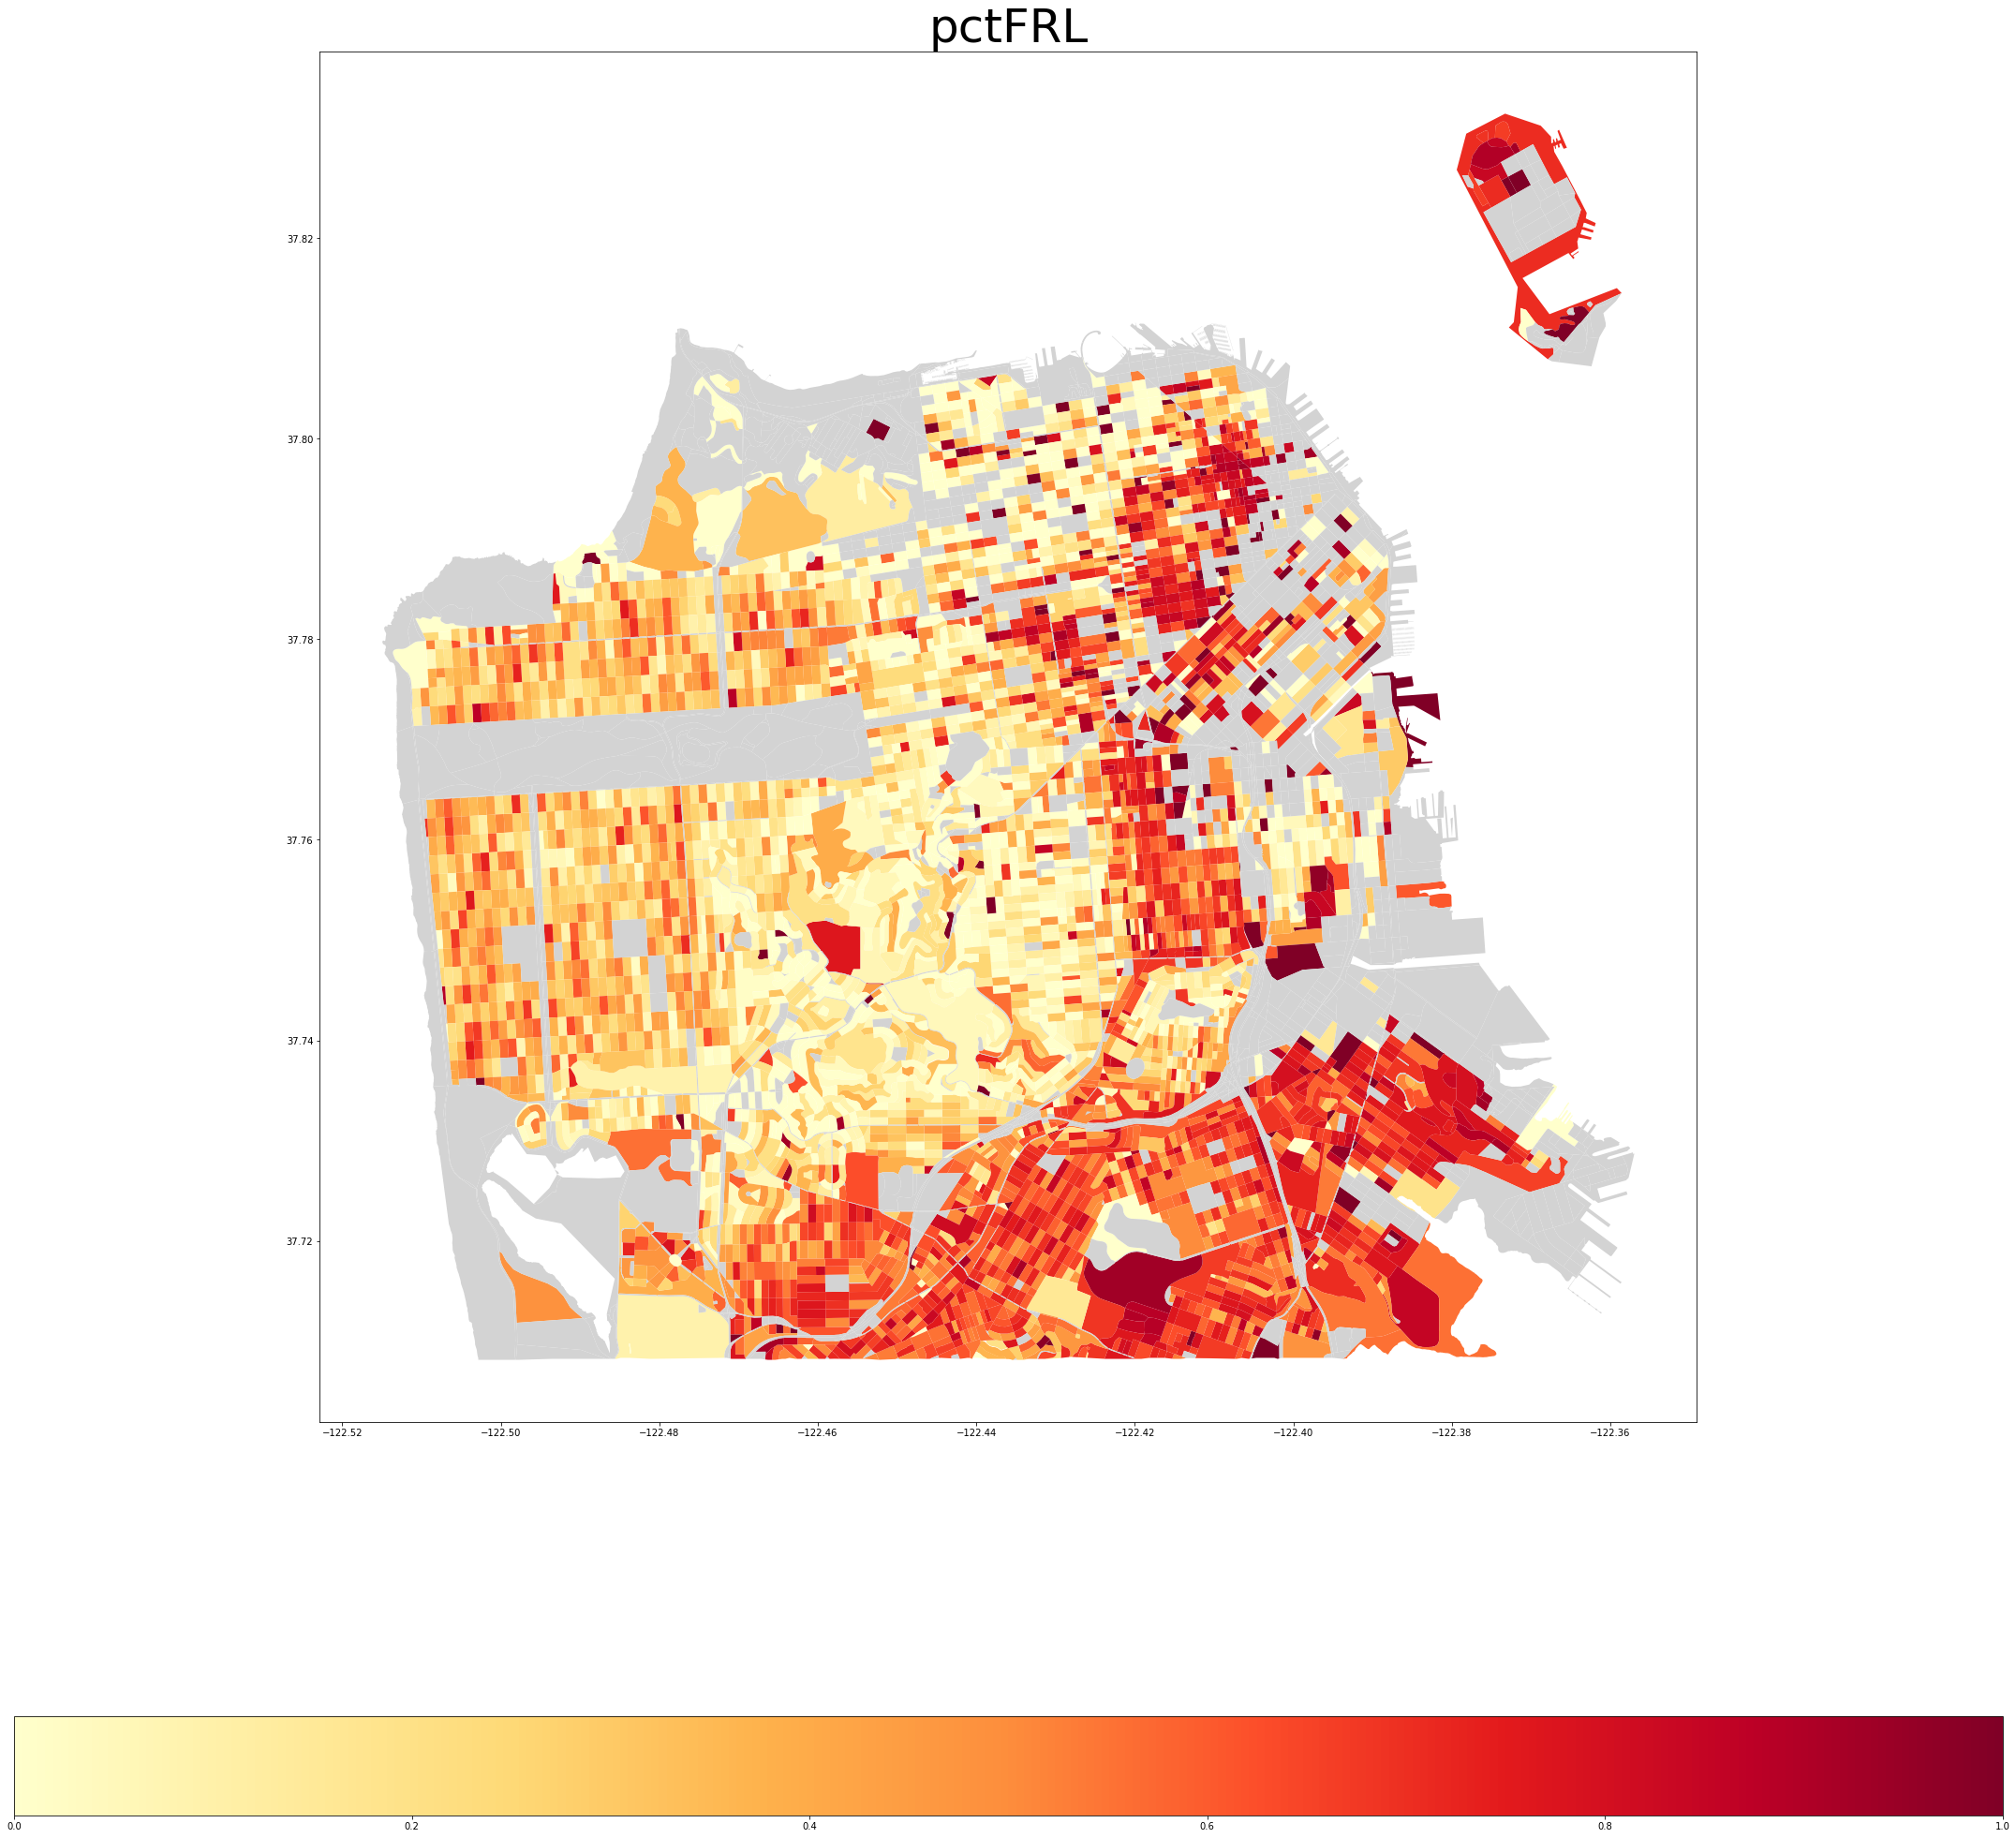

In [14]:
plot_column(sfusd_map_df, 'pctFRL', cmap="YlOrRd")

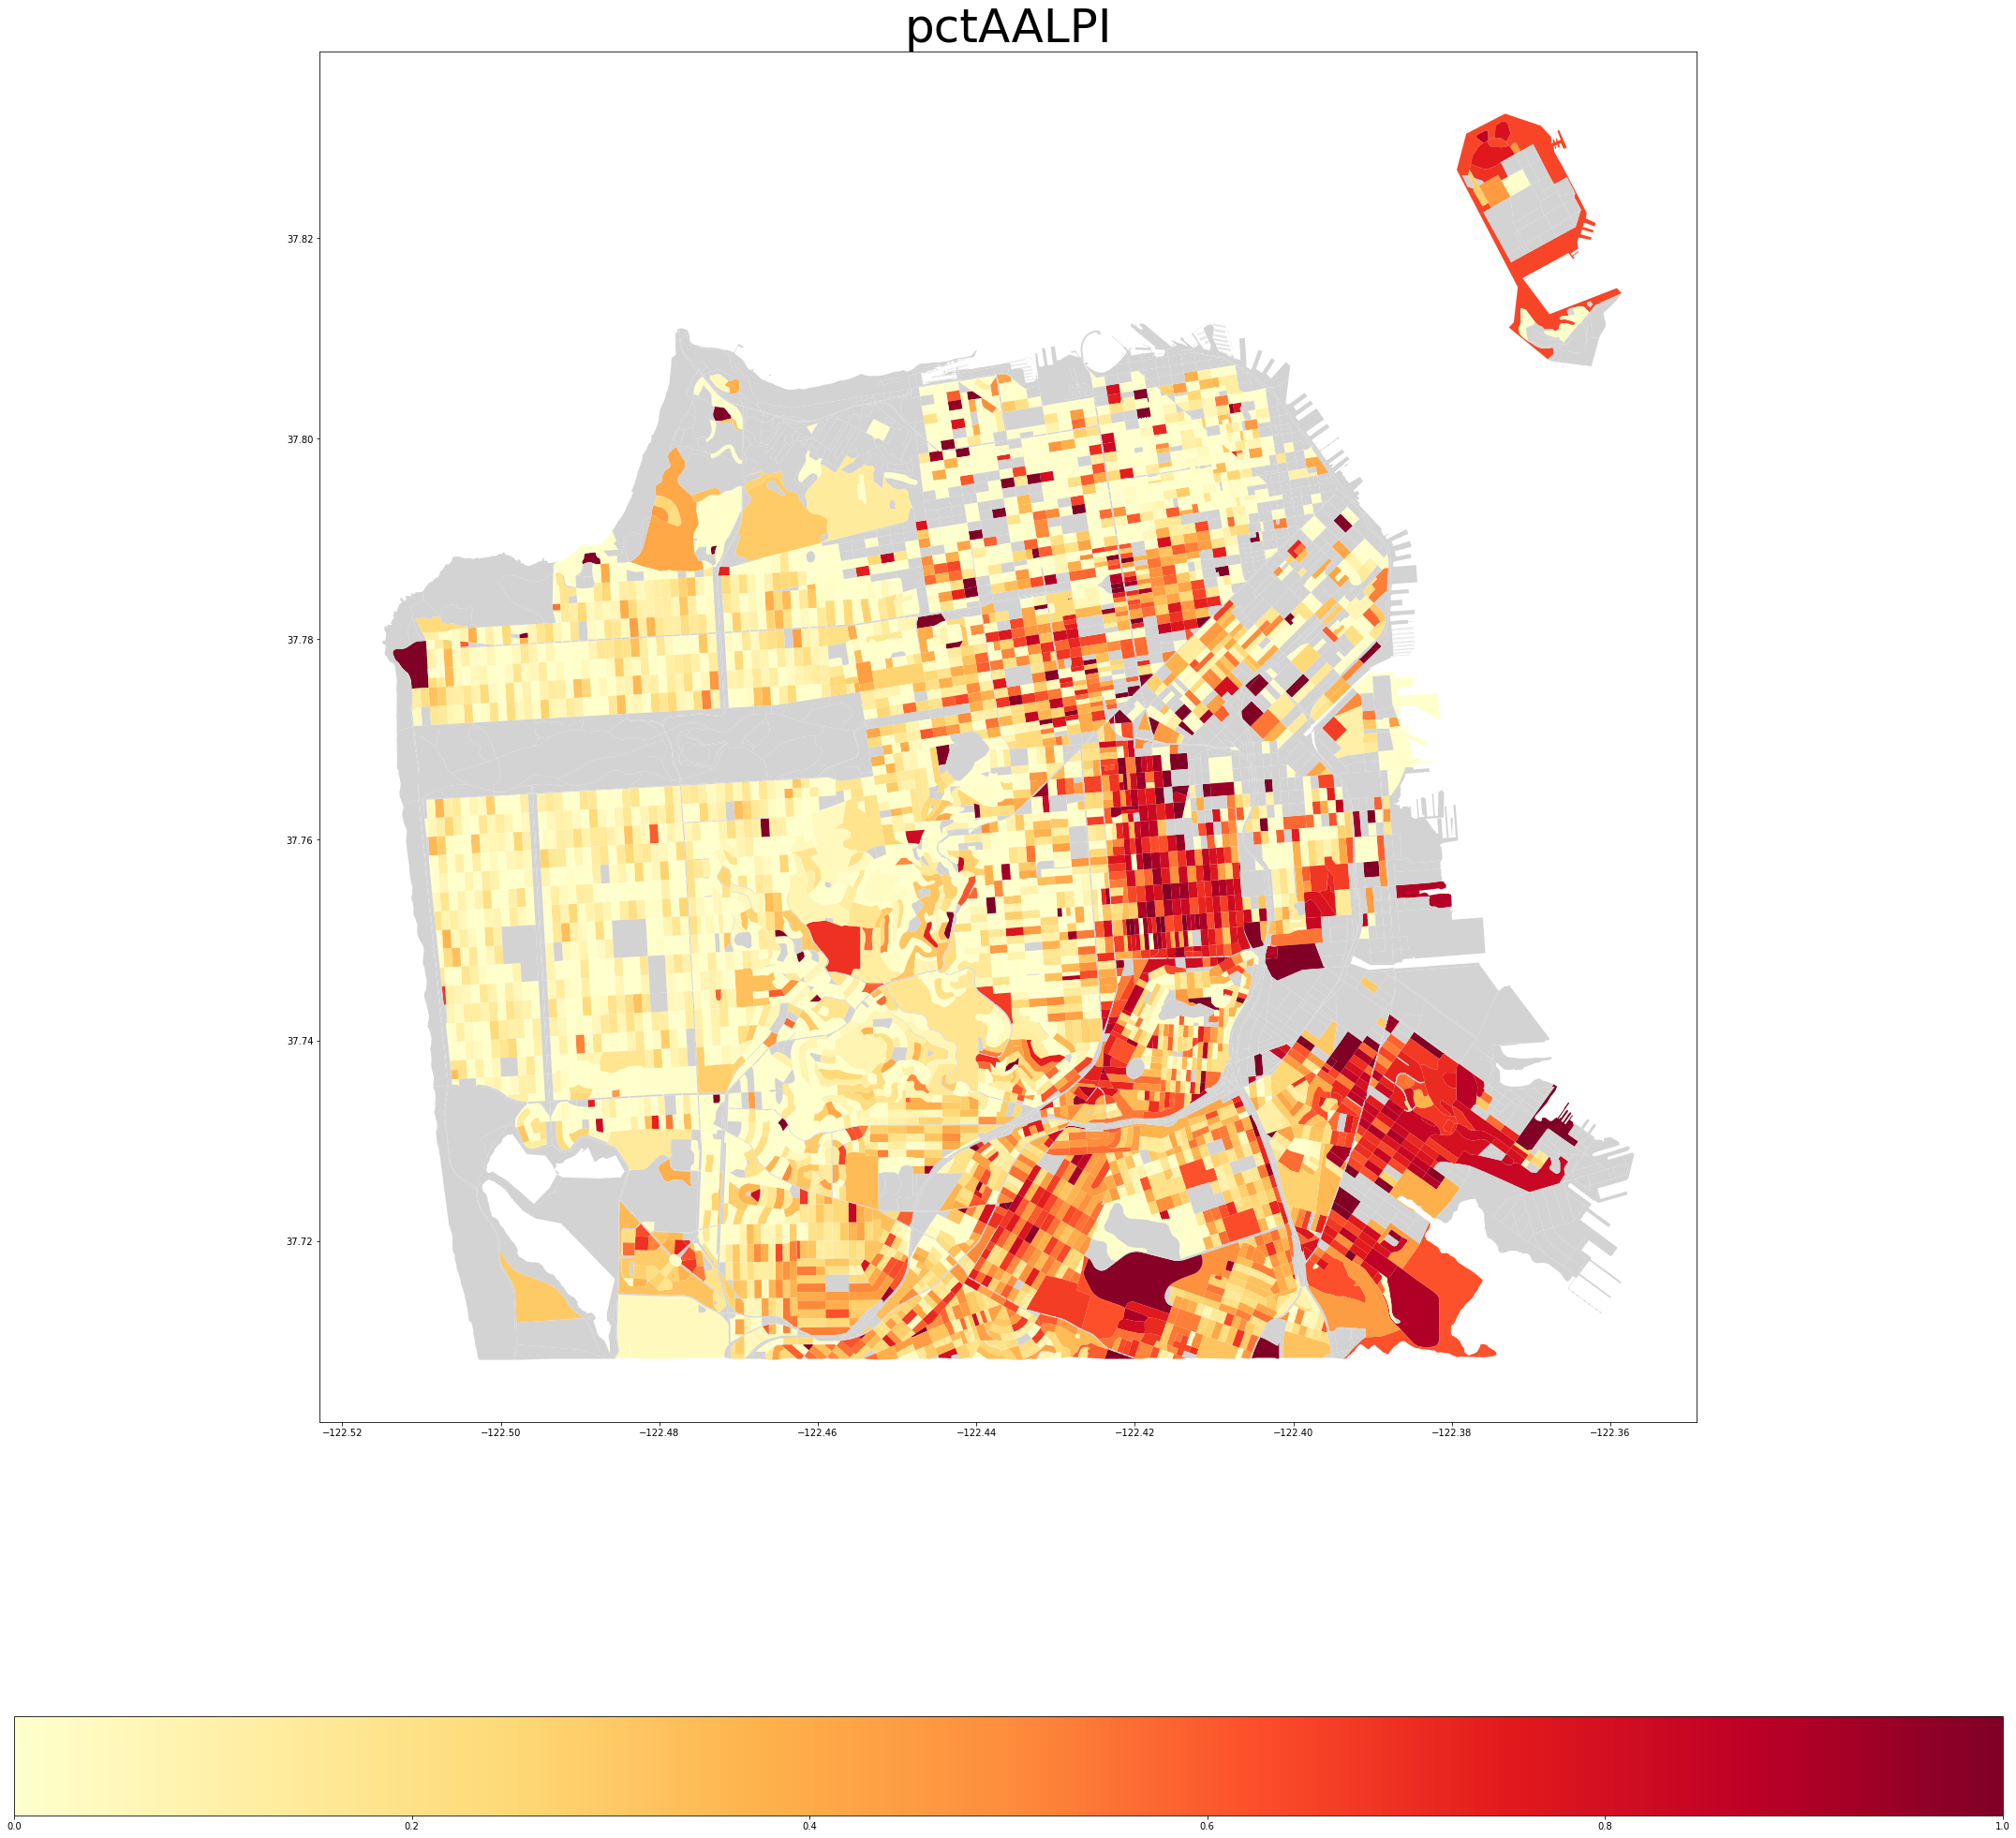

In [15]:
plot_column(sfusd_map_df, 'pctAALPI', cmap="YlOrRd")

# Knapsack Methodology

We are going to solve Knapsack problem for the block groups given by the `group` column.

In [16]:
data = df[['n', 'nFRL', 'group']].groupby('group').sum()
target_group = 'nFRL'
data['nOther'] = data['n'] - data[target_group]
data.dropna(inplace=True)
data = data.round().astype('int64')
data.describe()

,n,nFRL,nOther
count,3285.000000,3285.000000,3285.000000
mean,16.923896,8.870624,8.034399
std,15.675502,12.984109,4.992232
min,5.000000,0.000000,0.000000
25%,8.000000,2.000000,5.000000
50%,13.000000,5.000000,7.000000
75%,20.000000,11.000000,10.000000
max,201.000000,174.000000,77.000000


In [17]:
from src.d04_modeling.knapsack_approx import KnapsackApprox

solver = KnapsackApprox(eps=.5, data=data.copy(),
                            value_col=target_group,
                            weight_col='nOther',
                            scale=False)

if False:
    solver.solve()
    solver.save_value_function()
else:
    solver.load_value_function()
    

In [18]:
results = solver.get_value_per_weight()

In [55]:
solution_weights = solver.value_function[-1][:]
results = pd.Series(solution_weights, name='weights')
results.index.name = 'values'
results = results.to_frame().reset_index()
results = results.groupby('weights').max()
results.reset_index(inplace=True)
results['tpr'] = results['values'] / data[target_group].sum()
results['fpr'] = results['weights'] / data['nOther'].sum()
results

,weights,values,tpr,fpr
0,0.0,254,0.008717,0.000000
1,1.0,280,0.009609,0.000038
2,2.0,299,0.010261,0.000076
3,3.0,316,0.010844,0.000114
4,4.0,333,0.011428,0.000152
...,...,...,...,...
15625,22976.0,29136,0.999863,0.870534
15626,22996.0,29137,0.999897,0.871292
15627,23016.0,29138,0.999931,0.872049
15628,23038.0,29139,0.999966,0.872883


In [19]:
fp_rate = 0.1
fp = fp_rate * data['nOther'].sum()
print("False Positives Threshold: %i" % fp)

v_opt, solution_set = solver.get_solution(w_max=fp)
solution_set = pd.Index(solution_set, name=data.index.name)

False Positives Threshold: 2639


## Results

Lets see what our assignment looks like

In [20]:
data['focal'] = 0
data.loc[solution_set, 'focal'] = 1
data.groupby('focal').sum()

,n,nFRL,nOther
focal,,,
0,41785,17975,23754
1,13810,11165,2639


We can observe that the number of `nOther` labeled as `focal = 1` is roughly 10 percent of the total students.

In [21]:
def get_label(x, solution_set):
    if np.isfinite(x):
        return 1. if x in solution_set else 0.
    else:
        return np.nan

sfusd_map_df['focal'] = sfusd_map_df['group'].apply(lambda x: get_label(x, solution_set))

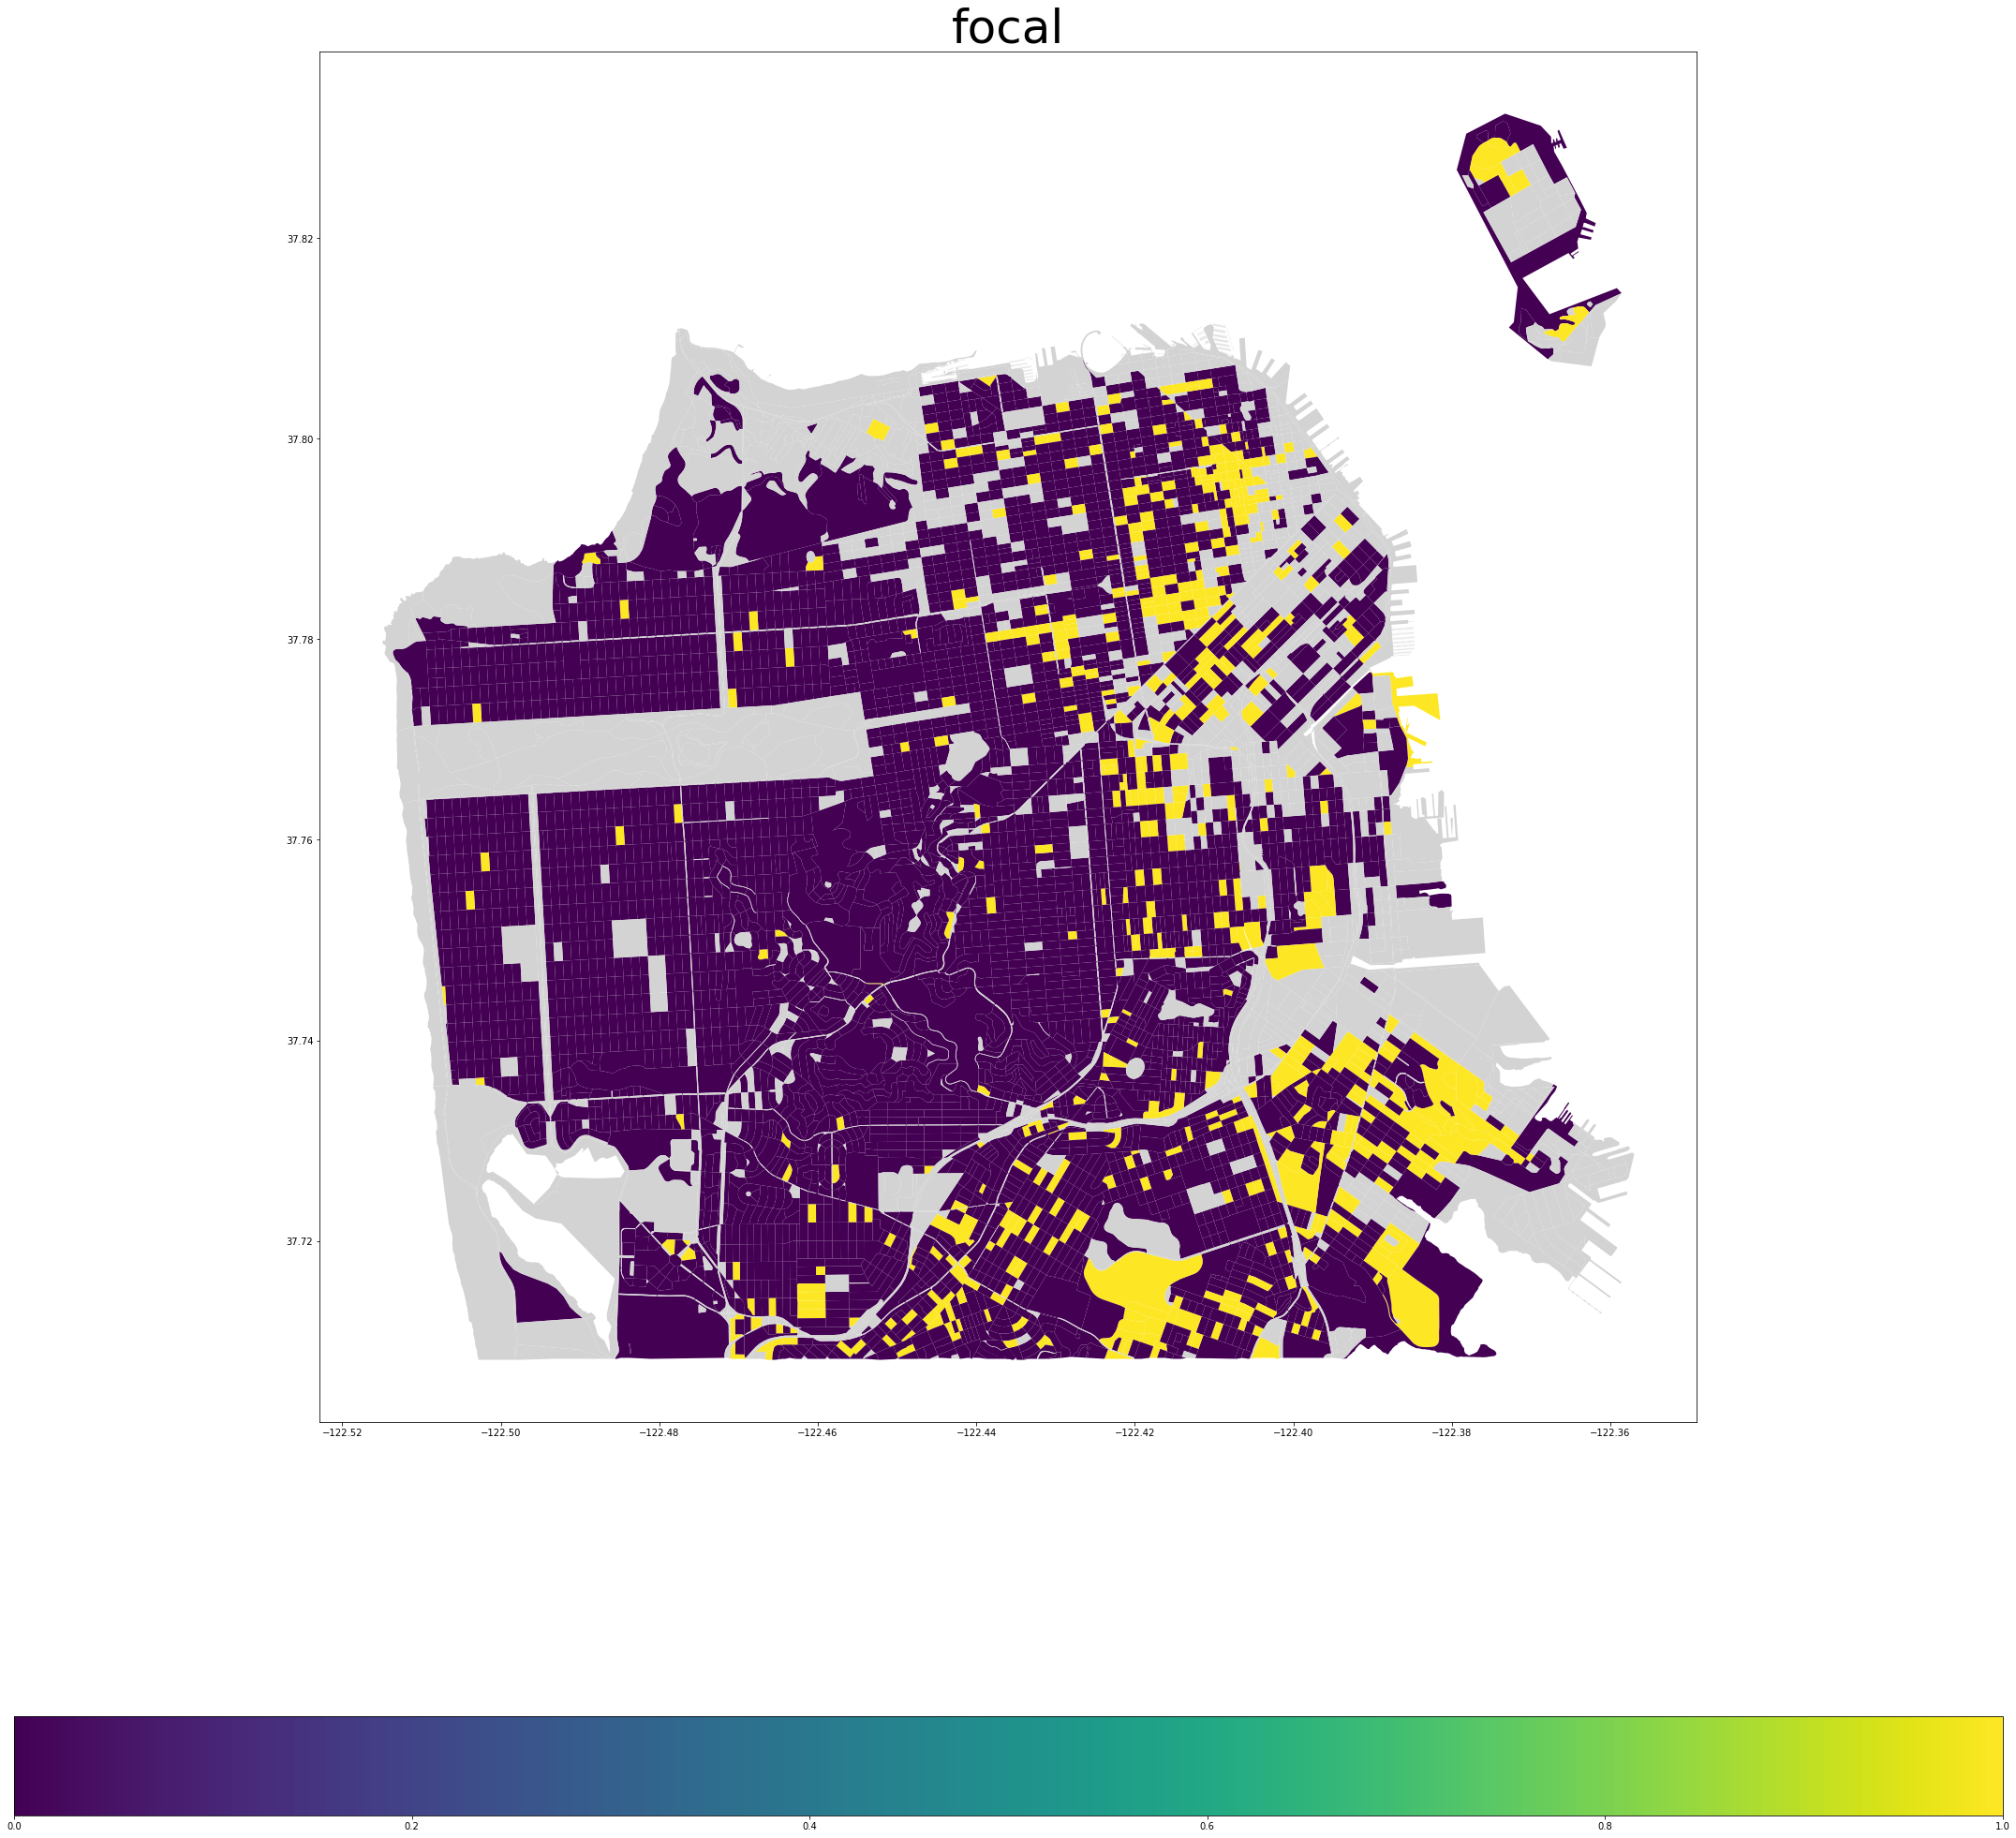

In [22]:
plot_column(sfusd_map_df, 'focal')

# Train Logistic Regression

We now use the labeled data to train a logistic regression over the aggregated block data

## Model

We can use the contribution of each block group to their label as weights for the training process. Let each block $b$ be of type $y=k$, with $k\in \{0,1\}$, have $v_b$ focal students and $u_b$ non-focal students. Then we can define the weight of each block $w_b$ in the training process as

$$w_b = \frac{\mathbb{I}(y_b=1)v_b + \mathbb{I}(y_b=0)u_b}{\sum_b\mathbb{I}(y_b=1)v_b + \mathbb{I}(y_b=0)u_b}$$

First we should inspect what our new labeled data set looks like

In [23]:
df_labeled = df.copy()
df_labeled['focal'] = df_labeled['group'].apply(lambda x: get_label(x, solution_set))
df_labeled.dropna(inplace=True)
df_labeled.head()

,BlockGroup,AALPI Score,Academic Score,Nhood SES Score,FRL Score,group,n,nFRL,nAALPI,nBoth,pctFRL,pctAALPI,pctBoth,focal
geoid,,,,,,,,,,,,,,
60750604001011,60750604001,0.292683,0.168000,0.559276,0.447084,3247.0,59.50,28.75,17.75,11.00,0.483193,0.298319,0.184874,0.0
60750179021025,60750179021,0.663343,0.854167,0.929991,0.856543,1315.0,9.75,9.00,4.50,4.25,0.923077,0.461538,0.435897,1.0
60750179021001,60750179021,0.663343,0.854167,0.929991,0.856543,3267.0,68.25,48.25,44.00,33.50,0.706960,0.644689,0.490842,0.0
60750179021027,60750179021,0.663343,0.854167,0.929991,0.856543,1672.0,12.00,8.00,9.50,6.75,0.666667,0.791667,0.562500,0.0
60750179021035,60750179021,0.663343,0.854167,0.929991,0.856543,2930.0,28.25,24.00,18.25,15.75,0.849558,0.646018,0.557522,1.0


We should also see what each block group looks like. Do they have the same demographic characteristics? Maybe this is an analysis that should have been done previously? Should we have grouped the blocks under the column `'BlockGroup'` instead of an psudo-arbitrary assigment (what Joseph did).

In [24]:
mask = df_labeled['group'] == 50
df_labeled.loc[mask]

,BlockGroup,AALPI Score,Academic Score,Nhood SES Score,FRL Score,group,n,nFRL,nAALPI,nBoth,pctFRL,pctAALPI,pctBoth,focal
geoid,,,,,,,,,,,,,,
60750201004005,60750201004,0.860163,0.630952,0.665830,0.747515,50.0,3.6,1.85,1.55,0.75,0.513889,0.430556,0.208333,0.0
60750158021000,60750158021,0.373984,0.173077,0.391240,0.215517,50.0,3.6,1.85,1.55,0.75,0.513889,0.430556,0.208333,0.0
60750202003008,60750202003,0.737282,0.381579,0.555210,0.538793,50.0,3.6,1.85,1.55,0.75,0.513889,0.430556,0.208333,0.0
60750206001008,60750206001,0.101996,0.169811,0.352273,0.179598,50.0,3.6,1.85,1.55,0.75,0.513889,0.430556,0.208333,0.0
60750312022009,60750312022,0.335128,0.347267,0.680362,0.589222,50.0,3.6,1.85,1.55,0.75,0.513889,0.430556,0.208333,0.0


It seems that blocks in the same `group` have different demographics. We are going to group and average the demographics. __Note__: _Since the counts are constant group counts, taking the average of these columns should yield the group counts. The same goes for the focal labels_

In [25]:
data_glm = df_labeled.groupby('group').mean()
data_glm['focal'] = data_glm['focal'].astype('int64')

In [26]:
data_glm.loc[50].to_frame().T

,BlockGroup,AALPI Score,Academic Score,Nhood SES Score,FRL Score,n,nFRL,nAALPI,nBoth,pctFRL,pctAALPI,pctBoth,focal
50.0,6.075022e+10,0.48171,0.340537,0.528983,0.454129,3.6,1.85,1.55,0.75,0.513889,0.430556,0.208333,0.0


In [27]:
data_glm['nOther'] = data_glm['n'] - data_glm[target_group]
summary = data_glm[['focal', 'n', 'nOther', target_group]].round().astype('int64')
summary = summary.groupby('focal').sum()
summary

,n,nOther,nFRL
focal,,,
0,38807,21373,17385
1,13439,2596,10838


In [28]:
summary / summary['n'].sum()

,n,nOther,nFRL
focal,,,
0,0.742775,0.409084,0.332753
1,0.257225,0.049688,0.207442


In [29]:
import statsmodels.api as sm

In [30]:
glm_covariates = df_labeled[_diversity_index_features].astype('float64')
glm_covariates['const'] = 1.
glm_covariates.head()

,AALPI Score,Academic Score,Nhood SES Score,FRL Score,const
geoid,,,,,
60750604001011,0.292683,0.168000,0.559276,0.447084,1.0
60750179021025,0.663343,0.854167,0.929991,0.856543,1.0
60750179021001,0.663343,0.854167,0.929991,0.856543,1.0
60750179021027,0.663343,0.854167,0.929991,0.856543,1.0
60750179021035,0.663343,0.854167,0.929991,0.856543,1.0


In [31]:
glm_response = df_labeled['focal']

In [32]:
glm_binom = sm.GLM(glm_response, glm_covariates, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  focal   No. Observations:                 4475
Model:                            GLM   Df Residuals:                     4470
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1330.1
Date:                Sat, 17 Jul 2021   Deviance:                       2660.1
Time:                        15:34:31   Pearson chi2:                 5.55e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
AALPI Score        -0.1411      0.301     